In [1]:
import pandas as pd
from torch import nn
import torch
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
import os 

In [2]:

test = pd.read_csv(r'F:\TANISHQ\kaggle-solutions\s4e7\test.csv\test.csv')
train = pd.read_csv(r'F:\TANISHQ\kaggle-solutions\s4e7\train.csv\train.csv')

In [3]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


# data cleaning nd preprocessing

policy_sales cahnnel is not imp

In [4]:
train['Vehicle_Age'].unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [6]:
train['Gender']=train['Gender'].astype(str)
train['Vehicle_Age']=train['Vehicle_Age'].astype(str)
train['Vehicle_Damage']=train['Vehicle_Damage'].astype(str)
test['Vehicle_Damage']=test['Vehicle_Damage'].astype(str)
test['Vehicle_Age']=train['Vehicle_Age'].astype(str)
test['Gender']=train['Gender'].astype(str)

In [7]:
le=LabelEncoder()
train['Gender'] = le.fit_transform(train['Gender'])
train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])
test['Gender'] = le.fit_transform(test['Gender'])
test['Vehicle_Damage'] = le.fit_transform(test['Vehicle_Damage'])


In [8]:
yera_mapping = {'1-2 Year': 1.5, '> 2 Years': 2.1,'< 1 Year':0.9}

train['Vehicle_Age'] = train['Vehicle_Age'].map(yera_mapping)
test['Vehicle_Age'] = test['Vehicle_Age'].map(yera_mapping)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                int32  
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           float64
 7   Vehicle_Damage        int32  
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(4), int32(2), int64(6)
memory usage: 965.5 MB


In [10]:
train=train[['Gender','Age','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Annual_Premium','Response']]
test=test[['id','Gender','Age','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Annual_Premium']]

In [11]:
test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium
0,11504798,1,20,1,47.0,0,1.5,0,2630.0
1,11504799,1,47,1,28.0,0,2.1,1,37483.0
2,11504800,0,47,1,43.0,0,0.9,1,2630.0
3,11504801,0,22,1,47.0,1,1.5,0,24502.0
4,11504802,0,51,1,19.0,0,1.5,0,34115.0
...,...,...,...,...,...,...,...,...,...
7669861,19174659,0,57,1,28.0,0,1.5,1,51661.0
7669862,19174660,0,28,1,50.0,1,1.5,0,25651.0
7669863,19174661,1,47,1,33.0,1,1.5,0,2630.0
7669864,19174662,0,30,1,28.0,0,0.9,1,38866.0


In [12]:
scaler = StandardScaler()
train[['Region_Code','Age','Annual_Premium']] = scaler.fit_transform(train[['Region_Code','Age','Annual_Premium']])
test[['Region_Code','Age','Annual_Premium']] = scaler.fit_transform(test[['Region_Code','Age','Annual_Premium']])

C:\Users\Shubham\AppData\Local\Temp\ipykernel_10276\1339895997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['Region_Code','Age','Annual_Premium']] = scaler.fit_transform(train[['Region_Code','Age','Annual_Premium']])


In [13]:
train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response
0,1,-1.159410,1,0.660528,0,1.5,1,2.105145,0
1,1,0.307897,1,0.121718,0,2.1,1,1.728962,1
2,0,-0.892627,1,-0.955902,1,0.9,0,0.460756,0
3,0,-0.225669,1,-1.956550,0,1.5,1,-1.691389,0
4,0,-0.158974,1,-0.878929,1,1.5,0,0.090529,0
...,...,...,...,...,...,...,...,...,...
11504793,1,0.641376,1,-1.571685,0,1.5,1,-0.185319,0
11504794,0,-0.825931,1,0.737501,0,0.9,1,-0.057878,1
11504795,0,-0.625844,1,0.429609,1,0.9,0,-1.691389,0
11504796,0,0.841463,1,0.121718,0,1.5,1,1.092793,1


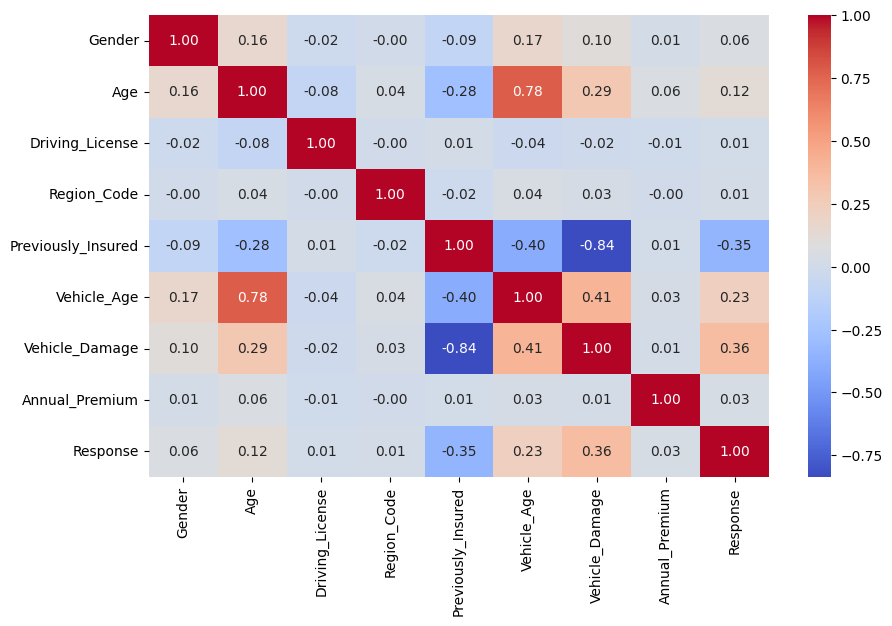

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),annot=True,cmap='coolwarm', fmt='.2f')  
plt.show()

In [15]:
train=train.drop('Previously_Insured',axis=1)
test=test.drop('Previously_Insured',axis=1)

In [16]:
test.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Vehicle_Age',
       'Vehicle_Damage', 'Annual_Premium'],
      dtype='object')

In [17]:
#making the data ready for the model
split_index = int(0.8 * len(train))
#performing the split
train_labels = np.array(train.iloc[:split_index]['Response'])
test_labels = np.array(train.iloc[split_index:]['Response'])
train_features = np.array(train.iloc[:split_index].drop('Response', axis=1))
test_features = np.array(train.iloc[split_index:].drop('Response', axis=1))
#train_features_np = train_features.to_numpy()  # Use .to_numpy() for conversion
#train_labels_np = train_labels.to_numpy()
#test_features_np = test_features.to_numpy()
#test_labels_np = test_labels.to_numpy()
# Convert NumPy arrays to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)  # Use dtype=torch.long if labels are integers
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)  

In [18]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        if labels is not None:
            self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create the dataset
dataset = CustomDataset(train_features_tensor, train_labels_tensor)
test_dataset = CustomDataset(test_features_tensor, test_labels_tensor)
# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [19]:
#for removing the issue of class imbalance
num_pos = train_labels.sum()
num_zeros = len(train_labels) - num_pos
pos_weight = num_zeros / num_pos
pos_weight = torch.tensor([pos_weight], dtype=torch.float32)

# making and testing the models.

In [20]:
class logistic_regression(nn.Module):
    def __init__(self):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(8, 10)
        self.hidden=nn.Linear(10,10)
        self.relu=nn.ReLU()
        self.output=nn.Linear(10,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x):
        x=self.linear(x)
        x=self.relu(x)
        x=self.hidden(x)
        x=self.relu(x)
        x=self.output(x)
        x=self.sigmoid(x)
        return (x)

In [21]:
class lr_improved(nn.Module):
    def __init__(self):
        super(lr_improved, self).__init__()
        self.linear = nn.Linear(7, 15)  # Increased number of neurons
        self.hidden = nn.Linear(15, 15)  # Increased number of neurons
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)  # Adjusted dropout rate
        self.output = nn.Linear(15, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

with normalization the loss was stagnating, and loss stagnated to 0.2688, but training got over very quickly in ~50 mins

trying with standardization, and got the same problems.

In [22]:
pos_weight

tensor([7.1257])

In [23]:
import numpy as np
#for removing the issue of class imbalance
num_pos = train_labels.sum()
num_zeros = len(train_labels) - num_pos
pos_weight = num_zeros / num_pos
pos_weight = torch.tensor([pos_weight], dtype=torch.float32)
model = lr_improved()
# Add weight decay (L2 regularization) to the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#model.to(device)
epochs = 5

# Training loop with tqdm
for epoch in range(epochs):
    epoch_loss = 0
    all_labels = []
    all_predictions = []
    
    model.train()
    
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
        for batch in pbar:
            features, labels = batch
            #features, labels = features.to(device), labels.to(device)  
            optimizer.zero_grad()
            predictions = model(features)
            predictions = predictions.squeeze(1)
            loss_value = loss_fn(predictions, labels)
            loss_value.backward()
            optimizer.step()
            
            # Accumulate the loss for the epoch
            epoch_loss += loss_value.item()

            # Store labels and predictions for accuracy and confusion matrix
            all_labels.extend(labels.cpu().tolist())
            # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
            binary_predictions = (predictions > 0.5).cpu().tolist()
            all_predictions.extend(binary_predictions)
    
    avg_loss = epoch_loss / len(dataloader)
    # Print the average loss for the epoch below the progress bar
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    # Calculate and print accuracy and F1 score for the epoch
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    print(f'Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

# After training, print confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
print(conf_matrix)   


Epoch 1/5: 100%|██████████| 287620/287620 [26:54<00:00, 178.15batch/s]


Epoch 1/5, Average Loss: 1.0873
Epoch 1/5, Accuracy: 0.7329, F1 Score: 0.4360


Epoch 2/5: 100%|██████████| 287620/287620 [26:38<00:00, 179.97batch/s]


Epoch 2/5, Average Loss: 1.0860
Epoch 2/5, Accuracy: 0.7332, F1 Score: 0.4373


Epoch 3/5: 100%|██████████| 287620/287620 [26:44<00:00, 179.29batch/s]


Epoch 3/5, Average Loss: 1.0857
Epoch 3/5, Accuracy: 0.7330, F1 Score: 0.4374


Epoch 4/5: 100%|██████████| 287620/287620 [26:16<00:00, 182.49batch/s]


Epoch 4/5, Average Loss: 1.0856
Epoch 4/5, Accuracy: 0.7328, F1 Score: 0.4375


Epoch 5/5: 100%|██████████| 287620/287620 [26:18<00:00, 182.26batch/s]


Epoch 5/5, Average Loss: 1.0856
Epoch 5/5, Accuracy: 0.7323, F1 Score: 0.4374
Confusion Matrix:
[[5782534 2288619]
 [ 175136  957549]]


Accuracy: 0.7216, F1 Score: 0.4344
Confusion Matrix:
[[1414208  604378]
 [  36308  246066]]


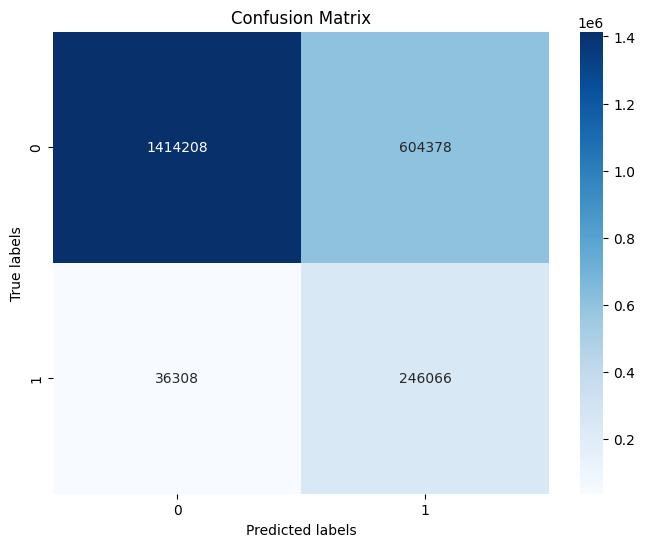

In [24]:
#getting the model in the evaluation mode
model.eval()

# Store all predictions for evaluation
all_predictions = []
all_predictions = []
all_labels = []

# Deactivate autograd engine
with torch.no_grad():
    for batch in test_dataloader:
        features, labels = batch
        #features, labels = features.to(device), labels.to(device)
        predictions = model(features)
        predictions = predictions.squeeze(1)
        binary_predictions = (predictions > 0.5).cpu().tolist()
        all_predictions.extend(binary_predictions)
        all_labels.extend(labels.cpu().tolist())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
print(conf_matrix)

#plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
id = test['id']
test_features_np = test.drop('id', axis=1).to_numpy()
test_features_ = torch.tensor(test_features_np, dtype=torch.float32)

batch_size = 32
test_dataloader_ = DataLoader(test_features_, batch_size=batch_size, shuffle=False)
all_predictions = []

# Deactivate autograd engine
model.eval()
with torch.no_grad():
    for test_features_tensor in test_dataloader_:
        predictions = model(test_features_tensor) 
        predictions = predictions.squeeze(1)
        binary_predictions = (predictions > 0.5).int().cpu().tolist()
        all_predictions.extend(binary_predictions)

# Prepare submission DataFrame
submission = pd.DataFrame({'id': id, 'Response': all_predictions})

# Define the file path
file_path = 'submission_ann_other.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    submission.to_csv(file_path, index=False)
    print(f"Saved the submission file to {file_path}")
else:
    print(f"File {file_path} already exists. Submission file was not saved.")

File submission_ann_other.csv already exists. Submission file was not saved.


In [26]:
submission['Response'].value_counts()

Response
0    4621801
1    3048065
Name: count, dtype: int64

1. with les number of variables.

    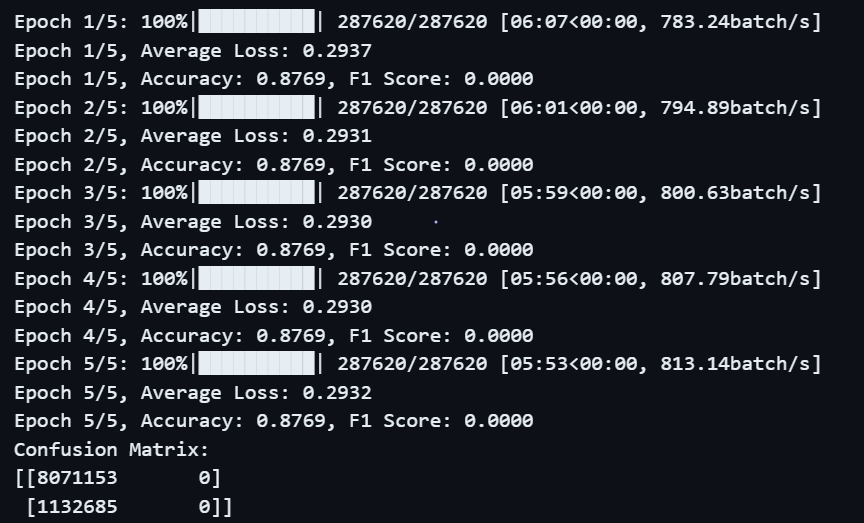
2. next we could try the lgbm 
3. with k fold cross validation technique with k=10

In [27]:
train_labels
test_labels
train_features
test_features

array([[ 1.        ,  2.50885666,  1.        , ...,  1.5       ,
         1.        , -0.35086357],
       [ 1.        , -1.22610565,  1.        , ...,  0.9       ,
         1.        ,  0.62247272],
       [ 1.        , -0.95932263,  1.        , ...,  0.9       ,
         1.        ,  0.39724893],
       ...,
       [ 0.        , -0.62584385,  1.        , ...,  0.9       ,
         0.        , -1.69138879],
       [ 0.        ,  0.84146277,  1.        , ...,  1.5       ,
         1.        ,  1.092793  ],
       [ 1.        , -0.89262687,  1.        , ...,  0.9       ,
         0.        ,  0.14546744]])

[LightGBM] [Info] Number of positive: 1132685, number of negative: 8071153
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 7
[LightGBM] [Warning] Setting max_bin to 63 is suggested for best performance
[LightGBM] [Info] Using GPU Device: Quadro P1000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (70.22 MB) transferred to GPU in 0.235765 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123067 -> initscore=-1.963705
[LightGBM] [Info] Start training from score -1.963705
Accuracy: 0.8773, F1 Score: 0.0000
Confusion Matrix:
[[2018586       0]
 [ 282374       0]]


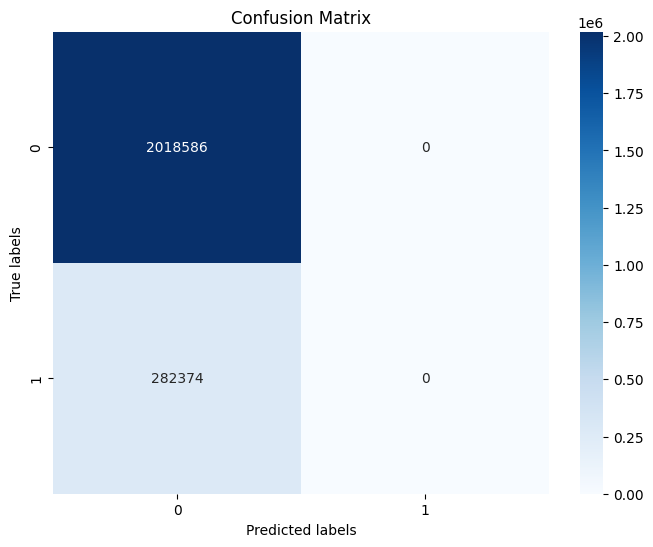

In [28]:
#trying lgbm 
train_data = lgb.Dataset(train_features, label=train_labels)
test_data = lgb.Dataset(test_features, label=test_labels, reference=train_data)

params = {
    'objective': 'binary', 
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.99,
    'verbose': 1,
    'device': 'gpu'
}

# Train the model
model_lgbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Make predictions
y_pred = model_lgbm.predict(test_features)
y_pred = (y_pred > 0.5).astype(int)

# Calculate accuracy and F1 score
accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [31]:
# Make predictions on the test set for the ligthgbm model
y_pred = model_lgbm.predict(test.drop('id', axis=1))
y_pred = (y_pred > 0.5).astype(int)

# Save the predictions to a CSV file
submission_light = pd.DataFrame({'id': test['id'], 'Response': y_pred})

flie_pth='submission_lgbm.csv'
if not os.path.exists(flie_pth):
    submission_light.to_csv(flie_pth, index=False)
    print(f"Saved the submission file to {flie_pth}")
else:
    print(f"File {flie_pth} already exists")
    
print(submission_light['Response'].value_counts())
submission_light

Saved the submission file to submission_lgbm.csv
Response
0    7669866
Name: count, dtype: int64


,id,Response
0,11504798,0
1,11504799,0
2,11504800,0
3,11504801,0
4,11504802,0
...,...,...
7669861,19174659,0
7669862,19174660,0
7669863,19174661,0
7669864,19174662,0


In [35]:
all_train_labels_tensor=torch.tensor(train['Response'].values, dtype=torch.float32)
all_train_tensor=torch.tensor(train.drop('Response',axis=1).values, dtype=torch.float32)

kf = KFold(n_splits=7, shuffle=True, random_state=42)

In [36]:
epochs = 5

# Store the metrics for each fold
fold_metrics = []
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for fold, (train_idx, val_idx) in enumerate(kf.split(all_train_tensor)):
    print(f'Fold {fold + 1}/{kf.get_n_splits()}')
    X_train, X_val = all_train_tensor[train_idx], all_train_tensor[val_idx]
    y_train, y_val = all_train_labels_tensor[train_idx], all_train_labels_tensor[val_idx]

    # Create model, loss function, and optimizer for this fold
    model_temp = lr_improved()
    num_pos_temp = y_train.sum()
    num_zeros_temp = len(y_train) - num_pos_temp
    pos_weight_temp = num_zeros_temp / num_pos_temp
    pos_weight_temp = torch.tensor([pos_weight_temp], dtype=torch.float32)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_temp)
    optimizer = torch.optim.Adam(model_temp.parameters(), lr=0.01, weight_decay=1e-5)

    # Create DataLoaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4)    
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=4)  
    
    for epoch in range(epochs):
        epoch_loss = 0
        all_labels = []
        all_predictions = []
        
        model.train()
        
        with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
            for batch in pbar:
                features, labels = batch
                #features, labels = features.to(device), labels.to(device) 
                optimizer.zero_grad()
                predictions = model(features)
                predictions = predictions.squeeze(1)
                loss_value = loss_fn(predictions, labels)
                loss_value.backward()
                optimizer.step()
                
                epoch_loss += loss_value.item()

                all_labels.extend(labels.cpu().numpy())
                binary_predictions = (predictions > 0.5).cpu().numpy()
                all_predictions.extend(binary_predictions)
        
        avg_loss = epoch_loss / len(train_dataloader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

    model_temp.eval()
    val_labels = []
    val_predictions = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            features, labels = batch
            #features, labels = features.to(device), labels.to(device)  
            predictions = model(features)
            predictions = predictions.squeeze(1)
            binary_predictions = (predictions > 0.5).cpu().tolist()
            val_labels.extend(labels.cpu().tolist())
            val_predictions.extend(binary_predictions)
    
    accuracy = accuracy_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)
    print(f'Fold {fold + 1}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
    fold_metrics.append((accuracy, f1))
    
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    print('Confusion Matrix:')
    print(conf_matrix)

# Calculate average metrics across all folds
avg_accuracy = np.mean([m[0] for m in fold_metrics])
avg_f1 = np.mean([m[1] for m in fold_metrics])
print(f'Average Accuracy: {avg_accuracy:.4f}, Average F1 Score: {avg_f1:.4f}')

Fold 1/7


Epoch 1/5: 100%|██████████| 308165/308165 [21:03<00:00, 243.93batch/s]


Epoch 1/5, Average Loss: 1.0855


Epoch 2/5: 100%|██████████| 308165/308165 [20:45<00:00, 247.41batch/s]


Epoch 2/5, Average Loss: 1.0856


Epoch 3/5:  75%|███████▌  | 231740/308165 [15:58<05:13, 243.81batch/s]

In [ ]:
model_temp.eval()
with torch.no_grad():
    for test_features_tensor in test_dataloader_:
        predictions = model_temp(test_features_tensor) 
        predictions = predictions.squeeze(1)
        binary_predictions = (predictions > 0.5).int().cpu().tolist()
        all_predictions.extend(binary_predictions)

# Prepare submission DataFrame
submission_temp = pd.DataFrame({'id': id, 'Response': all_predictions})

# Define the file path
file_path = 'submission_kfold.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    submission.to_csv(file_path, index=False)
    print(f"Saved the submission file to {file_path}")
else:
    print(f"File {file_path} already exists. Submission file was not saved.")